# Development of SNAP for Cu

## 1. Data loading, Feature analysis and ML model training

### 1.1 Import necessary packages

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from monty.serialization import loadfn
from maml.utils import pool_from, convert_docs

# local environment descriptors imports
from maml.describers import BispectrumCoefficients
from sklearn.decomposition import PCA

# machine learning interatomic potentials imports
from maml.base import SKLModel
from maml.apps.pes import SNAPotential
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# materials properties prediction imports
from pymatgen.core import Structure, Lattice
from maml.apps.pes import LatticeConstant, ElasticConstant, NudgedElasticBand, DefectFormation

# disable logging information
import logging
logging.disable(logging.CRITICAL)

### 1.2 Load DFT data

loadfn - loads json directly from a filename instead of a file-like object

In [2]:
Cu_train_data = loadfn('../data/Cu/training.json')
Cu_test_data = loadfn('../data/Cu/test.json')
print(' # of Cu training data: {}\n'.format(len(Cu_train_data)),
      '# of Cu test data: {}\n'.format(len(Cu_test_data)))

 # of Cu training data: 262
 # of Cu test data: 31



### 1.3 Bispectrum coefficients features

Transform each atom in structures to one array of feature, set pot_fit = False

Bispectrum coefficients to describe the local environment of each atom. Lammps is required to perform this computation.

In [3]:
element_profile = {'Cu': {'r': 0.5, 'w': 1.0}}
per_atom_describer = BispectrumCoefficients(rcutfac=4.1, twojmax=8, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=False, 
                                                 include_stress=False)

Cu_train_structures = [d['structure'] for d in Cu_train_data]
per_atom_features = per_atom_describer.transform(Cu_train_structures)

print("Total # of atoms in Cu train: {}\n".format(sum([len(struct) for struct in Cu_train_structures])), 
      "     # of features generated: {} (one feature per atom)\n".format(per_atom_features.shape[0]),
      "     # of dimensions: {} (for twojmax = 8)".format(per_atom_features.shape[1]))

per_atom_features

Total # of atoms in Cu train: 27416
      # of features generated: 27416 (one feature per atom)
      # of dimensions: 55 (for twojmax = 8)


0-0-0    1-0-1     1-1-2    2-0-2    2-1-3     2-2-2  \
input_index                                                               
0           0    123.782  2.78208  0.225312  4.10480 -1.79423  0.360214   
            1    130.162  2.32429  0.274841  4.35532 -1.62485  0.338583   
            2    107.891  2.40000  0.267426  5.79408 -2.08125  0.661971   
            3    123.718  3.05087  0.399140  5.78889 -2.16736  0.493988   
            4    108.321  3.43089  0.765592  7.81835 -3.07641  1.145910   
...                  ...      ...       ...      ...      ...       ...   
261         103  119.831  3.06292  0.552629  5.20118 -2.46562  0.625617   
            104  119.831  3.06292  0.552629  5.20118 -2.46562  0.625617   
            105  119.831  3.06292  0.552629  5.20118 -2.46562  0.625617   
            106  119.831  3.06289  0.552614  5.20104 -2.46557  0.625590   
            107  119.831  3.06289  0.552614  5.20104 -2.46557  0.625590   

                   2-2-4    3-0-3    3-1-4    3-2-3  ...    7-3-8     7-4-7  \
input_index                                          ...                      
0           0    1.08228  69.1946 -3.57477  6.61807  ...  20.0347   8.76624   
            1    1.02788  68.5448 -3.96349  6.04841  ...  19.0123  10.13760   
            2    1.50903  64.0157 -2.97810  7.57734  ...  21.1753   7.72521   
            3    1.41427  66.6348 -3.91399  7.27774  ...  20.3323   9.60337   
            4    1.98036  63.1501 -3.97189  9.37485  ...  19.7767   5.48806   
...                  ...      ...      ...      ...  ...      ...       ...   
261         103  1.50493  68.5919 -4.44831  8.25048  ...  19.0800   6.83769   
            104  1.50493  68.5919 -4.44831  8.25048  ...  19.0800   6.83769   
            105  1.50493  68.5919 -4.44831  8.25048  ...  19.0800   6.83769   
            106  1.50490  68.5922 -4.44831  8.25038  ...  19.0799   6.83782   
            107  1.50490  68.5922 -4.44831  8.25038  ...  19.0799   6.83782   

                   7-5-8    7-6-7    7-7-8    8-0-8     8-2-8     8-4-8  \
input_index                                                               
0           0    9.00867  32.8991  7.83683  79.4506  1.586570  2.764680   
            1    6.99879  32.5513  9.99829  77.2745  1.089990  3.561750   
            2    8.81881  28.2623  6.13059  77.9411  2.775480  3.285700   
            3    7.28432  31.0522  8.28628  77.8362  1.436630  2.985120   
            4    5.82751  27.2870  2.14979  70.7974  1.825390  0.503251   
...                  ...      ...      ...      ...       ...       ...   
261         103  4.86225  35.6635  1.56776  61.5279 -0.024746 -0.474948   
            104  4.86225  35.6635  1.56776  61.5279 -0.024746 -0.474948   
            105  4.86225  35.6635  1.56776  61.5279 -0.024746 -0.474948   
            106  4.86221  35.6639  1.56792  61.5277 -0.024783 -0.474917   
            107  4.86221  35.6639  1.56792  61.5277 -0.024783 -0.474917   

                    8-6-8    8-8-8  
input_index                         
0           0    4.790880  11.9689  
            1    3.631350  10.4115  
            2    7.119790  11.9819  
            3    5.503750  10.9735  
            4    4.824390  13.2390  
...                   ...      ...  
261         103 -0.025615  12.7171  
            104 -0.025615  12.7171  
            105 -0.025615  12.7171  
            106 -0.025732  12.7170  
            107 -0.025732  12.7170  

[27416 rows x 55 columns]

Transform each structure to one feature for structure and one feature for each atomic force component, set **pot_fit = True**

The dimension of features is 31 instead of 30. There is one extra intercept term at the beginning of the feature. This term is disminished for forces as the intercept disappears in the derivative of the energy.

In [4]:
element_profile = {'Cu': {'r': 0.5, 'w': 1.0}}
per_force_describer = BispectrumCoefficients(rcutfac=4.1, twojmax=8, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=True, 
                                                 include_stress=False)

Cu_train_structures = [d['structure'] for d in Cu_train_data]
per_force_features = per_force_describer.transform(Cu_train_structures)

print("Total # of features expected in Cu: {}\n".format(sum([(1 + 3 * len(struct)) for struct in Cu_train_structures])), 
      "     # of features generated: {} (1+3n features for n-atom structure)\n".format(per_force_features.shape[0]),
      "     # of dimensions: {}".format(per_force_features.shape[1]))

per_force_features

Total # of features expected in Cu: 82510
      # of features generated: 82510 (1+3n features for n-atom structure)
      # of dimensions: 56


Cu                                                      \
                     n       0-0-0     1-0-1     1-1-2     2-0-2     2-1-3   
input_index                                                                  
0           0      1.0  115.235266  2.828200  0.422333  6.367622 -2.230816   
            0_x    0.0   17.658400  1.834800 -0.216947  2.877070  0.244974   
            0_y    0.0  -10.649200 -4.441490  1.935390 -2.845080 -0.988647   
            0_z    0.0  -28.909200 -3.402200  0.829880 -9.796710 -1.099540   
            1_x    0.0   21.062400  0.447715 -0.258357 -4.293710  0.166989   
...                ...         ...       ...       ...       ...       ...   
261         106_y  0.0    0.000540  0.000110 -0.000047  0.000164  0.000025   
            106_z  0.0    0.000540  0.000110 -0.000047  0.000164  0.000025   
            107_x  0.0    0.000540  0.000110 -0.000047  0.000164  0.000025   
            107_y  0.0    0.000540  0.000110 -0.000047  0.000164  0.000025   
            107_z  0.0   -0.000540 -0.000110  0.000047 -0.000164 -0.000025   

                                                            ...             \
                      2-2-2     2-2-4      3-0-3     3-1-4  ...      7-3-8   
input_index                                                 ...              
0           0      0.658986  1.517099  64.020621 -3.644542  ...  19.757430   
            0_x    0.822336  0.232736 -21.476900  2.761800  ...   5.562870   
            0_y   -0.086212 -0.014522  16.528900 -8.796640  ...   7.978140   
            0_z   -3.121590 -0.676476  43.111100 -3.942510  ... -11.787900   
            1_x   -0.541881  0.439486   4.209120 -1.197280  ...   3.261420   
...                     ...       ...        ...       ...  ...        ...   
261         106_y  0.000075  0.000028  -0.000753  0.000351  ...   0.000442   
            106_z  0.000075  0.000028  -0.000753  0.000351  ...   0.000442   
            107_x  0.000075  0.000028  -0.000753  0.000351  ...   0.000442   
            107_y  0.000075  0.000028  -0.000753  0.000351  ...   0.000442   
            107_z -0.000075 -0.000028   0.000753 -0.000351  ...  -0.000442   

                                                                          \
                       7-4-7      7-5-8      7-6-7     7-7-8       8-0-8   
input_index                                                                
0           0       8.289720   7.833857  29.159737   6.68260   75.980440   
            0_x    16.438900  14.856100 -27.048500  36.75540   82.859800   
            0_y    -0.220487 -21.185700  14.343300 -22.33680  -68.218900   
            0_z   -12.211100 -35.340500  65.299800 -48.62560 -196.055000   
            1_x     2.624120   0.297745  19.462700  -3.85550    0.873806   
...                      ...        ...        ...       ...         ...   
261         106_y   0.000706   0.001064  -0.000943   0.00183    0.004700   
            106_z   0.000706   0.001064  -0.000943   0.00183    0.004700   
            107_x   0.000706   0.001064  -0.000943   0.00183    0.004700   
            107_y   0.000706   0.001064  -0.000943   0.00183    0.004700   
            107_z  -0.000706  -0.001064   0.000943  -0.00183   -0.004700   

                                                               
                       8-2-8      8-4-8      8-6-8      8-8-8  
input_index                                                    
0           0       2.028676   2.753590   5.471632  11.452464  
            0_x     8.457730  16.488300  19.205200   3.610910  
            0_y   -12.988400 -21.948300 -21.437100  -9.782860  
            0_z   -27.085300 -34.669500 -57.504600 -13.565300  
            1_x    -4.242970   1.344670 -14.310300  15.736100  
...                      ...        ...        ...        ...  
261         106_y   0.000787   0.001189   0.001909  -0.000471  
            106_z   0.000787   0.001189   0.001909  -0.000471  
            107_x   0.000787   0.001189   0.001909  -0.000471  
 

### 1.4 Using PCA to visualize feature space

A reasonable set of structures for potential fitting tends to provide a good coverage of the feature space. However, 
distribution of features with 30 dimensions is impossible to visualize. We need to reduce the dimensions while maintaining most of the information. [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is one of the most important dimension reduction algorithms. PCA keeps the first two principal components which maximize the variances (information) between the features.

transform - transforms a list of objects to one or a list of pandas data frame/numpy ndarray

In [5]:
# Obtain structures from each categories
Cu_train_structures = [d['structure'] for d in Cu_train_data]
Cu_test_structures = [d['structure'] for d in Cu_test_data]

# Obtain the features from each categories
Cu_train_features = per_atom_describer.transform(Cu_train_structures)
Cu_test_features = per_atom_describer.transform(Cu_test_structures)

# Add up features
total_Cu_features = np.concatenate((Cu_train_features, Cu_test_features), axis=0)

# Fit the PCA
pca = PCA(n_components=2)
pca.fit(total_Cu_features)

Cu_train_pcs = pca.transform(Cu_train_features)
Cu_train_pc1 = Cu_train_pcs[:, 0]
Cu_train_pc2 = Cu_train_pcs[:, 1]

Cu_test_pcs = pca.transform(Cu_test_features)
Cu_test_pc1 = Cu_test_pcs[:, 0]
Cu_test_pc2 = Cu_test_pcs[:, 1]

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Visualization of PCA : x axis is the first principal component (PC1) and y axis is the second principal component (PC2).

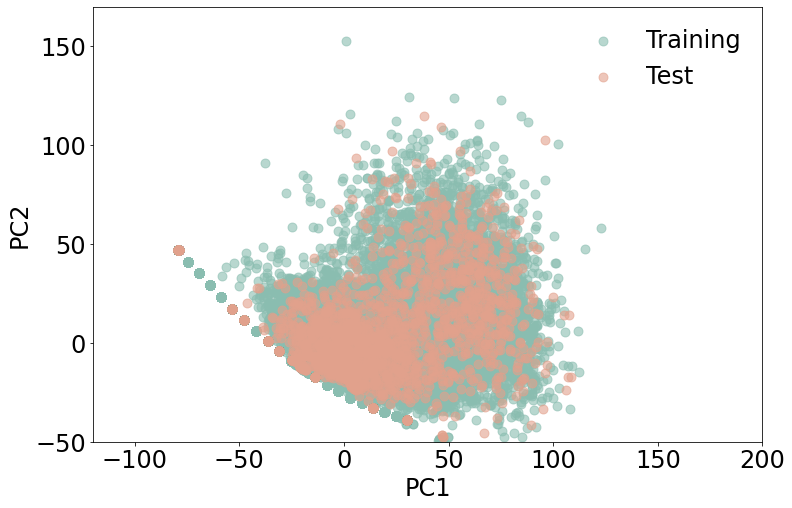

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(Cu_train_pc1, Cu_train_pc2, c='#8ABDB0', alpha=0.6, s=80, label='Training')
ax.scatter(Cu_test_pc1, Cu_test_pc2, c='#E2A18C', alpha=0.6, s=80, label='Test')

from matplotlib import ticker

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

plt.legend(fontsize=24, frameon=False)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.xlim(-120, 200)
plt.ylim(-50, 170)

plt.savefig('images/Cu_pca.png', bbox_inches='tight')

### 1.5 Use the DFT-computed energy and forces as targets and train linear regression model

Split the dataset into three lists:
 - list of structure objects [Structure object for each structure]
 - list of energies [total_energy for each structure], 
 - list of forces [n x 3 forces array for each n-atom structure], n can be different for different structures.

In [8]:
Cu_train_structures = [d['structure'] for d in Cu_train_data]
Cu_train_energies = [d['outputs']['energy'] for d in Cu_train_data]
Cu_train_forces = [d['outputs']['forces'] for d in Cu_train_data]

print(" # of structures in Cu data: {}\n".format(len(Cu_train_structures)),
      "# of energies in Cu data: {}\n".format(len(Cu_train_energies)),
      "# of forces in Cu data: {}\n".format(len(Cu_train_forces)),
      "first item in energies: {}\n".format(Cu_train_energies[0]),
      "first item in forces: (n x 3 array)\n", np.array(Cu_train_forces[0]))

 # of structures in Cu data: 262
 # of energies in Cu data: 262
 # of forces in Cu data: 262
 first item in energies: -426.29982847
 first item in forces: (n x 3 array)
 [[ 0.66566644 -1.15457477 -1.39804032]
 [-0.16469973  1.12617361 -0.68775326]
 [ 0.2086571  -1.08711154  1.30313082]
 [ 1.00001504 -0.73012132  0.27457311]
 [ 0.02766732 -0.08356301  0.00230339]
 [-0.5588753  -0.77403386 -0.60073534]
 [ 0.8816575   0.56752068 -0.80069926]
 [-1.0161593   0.29006985 -1.35020372]
 [ 0.08856013 -0.33428209 -0.41140353]
 [-0.88903649 -0.9629131   0.30170334]
 [-0.09214141 -0.77792301  0.56438719]
 [-0.36033496  0.74935316 -0.28525965]
 [ 0.49953162  0.63601683 -0.0346367 ]
 [ 0.4137092   0.96846444  0.48535956]
 [ 0.17078007 -0.74665862 -0.95252656]
 [ 1.05969307 -0.28307848 -0.71396327]
 [-1.43618895 -1.49983801  0.83123564]
 [ 0.30479962  0.21138782 -0.21327366]
 [-0.41517074  0.26502478  0.06411987]
 [-0.77189477  0.08531227  0.06017606]
 [ 0.20697062 -0.49383221 -0.22277234]
 [-0.509743

Let's use the features with pot_fit = True, i.e., 1+3n features for n-atom structure

In [9]:
Cu_features = per_force_features
print("# of features generated: {}".format(Cu_features.shape[0]))
Cu_features

# of features generated: 82510


Cu                                                      \
                     n       0-0-0     1-0-1     1-1-2     2-0-2     2-1-3   
input_index                                                                  
0           0      1.0  115.235266  2.828200  0.422333  6.367622 -2.230816   
            0_x    0.0   17.658400  1.834800 -0.216947  2.877070  0.244974   
            0_y    0.0  -10.649200 -4.441490  1.935390 -2.845080 -0.988647   
            0_z    0.0  -28.909200 -3.402200  0.829880 -9.796710 -1.099540   
            1_x    0.0   21.062400  0.447715 -0.258357 -4.293710  0.166989   
...                ...         ...       ...       ...       ...       ...   
261         106_y  0.0    0.000540  0.000110 -0.000047  0.000164  0.000025   
            106_z  0.0    0.000540  0.000110 -0.000047  0.000164  0.000025   
            107_x  0.0    0.000540  0.000110 -0.000047  0.000164  0.000025   
            107_y  0.0    0.000540  0.000110 -0.000047  0.000164  0.000025   
            107_z  0.0   -0.000540 -0.000110  0.000047 -0.000164 -0.000025   

                                                            ...             \
                      2-2-2     2-2-4      3-0-3     3-1-4  ...      7-3-8   
input_index                                                 ...              
0           0      0.658986  1.517099  64.020621 -3.644542  ...  19.757430   
            0_x    0.822336  0.232736 -21.476900  2.761800  ...   5.562870   
            0_y   -0.086212 -0.014522  16.528900 -8.796640  ...   7.978140   
            0_z   -3.121590 -0.676476  43.111100 -3.942510  ... -11.787900   
            1_x   -0.541881  0.439486   4.209120 -1.197280  ...   3.261420   
...                     ...       ...        ...       ...  ...        ...   
261         106_y  0.000075  0.000028  -0.000753  0.000351  ...   0.000442   
            106_z  0.000075  0.000028  -0.000753  0.000351  ...   0.000442   
            107_x  0.000075  0.000028  -0.000753  0.000351  ...   0.000442   
            107_y  0.000075  0.000028  -0.000753  0.000351  ...   0.000442   
            107_z -0.000075 -0.000028   0.000753 -0.000351  ...  -0.000442   

                                                                          \
                       7-4-7      7-5-8      7-6-7     7-7-8       8-0-8   
input_index                                                                
0           0       8.289720   7.833857  29.159737   6.68260   75.980440   
            0_x    16.438900  14.856100 -27.048500  36.75540   82.859800   
            0_y    -0.220487 -21.185700  14.343300 -22.33680  -68.218900   
            0_z   -12.211100 -35.340500  65.299800 -48.62560 -196.055000   
            1_x     2.624120   0.297745  19.462700  -3.85550    0.873806   
...                      ...        ...        ...       ...         ...   
261         106_y   0.000706   0.001064  -0.000943   0.00183    0.004700   
            106_z   0.000706   0.001064  -0.000943   0.00183    0.004700   
            107_x   0.000706   0.001064  -0.000943   0.00183    0.004700   
            107_y   0.000706   0.001064  -0.000943   0.00183    0.004700   
            107_z  -0.000706  -0.001064   0.000943  -0.00183   -0.004700   

                                                               
                       8-2-8      8-4-8      8-6-8      8-8-8  
input_index                                                    
0           0       2.028676   2.753590   5.471632  11.452464  
            0_x     8.457730  16.488300  19.205200   3.610910  
            0_y   -12.988400 -21.948300 -21.437100  -9.782860  
            0_z   -27.085300 -34.669500 -57.504600 -13.565300  
            1_x    -4.242970   1.344670 -14.310300  15.736100  
...                      ...        ...        ...        ...  
261         106_y   0.000787   0.001189   0.001909  -0.000471  
            106_z   0.000787   0.001189   0.001909  -0.000471  
            107_x   0.000787   0.001189   0.001909  -0.000471  
 

pool_from - Method to convert structures and their properties in to datapool format; ([dict]) returned

convert_docs - http://maml.ai/maml.utils.html?highlight=convert_docs#maml.utils.convert_docs

In [10]:
Cu_train_pool = pool_from(Cu_train_structures, Cu_train_energies, Cu_train_forces)
_, Cu_df = convert_docs(Cu_train_pool)
print("# of targets: ", len(Cu_df))
Cu_df

# of targets:  82510


,y_orig,n,dtype
0,-426.299828,107.0,energy
1,0.665666,1.0,force
2,-1.154575,1.0,force
3,-1.398040,1.0,force
4,-0.164700,1.0,force
...,...,...,...
82505,-0.000892,1.0,force
82506,-0.000710,1.0,force
82507,-0.000122,1.0,force
82508,-0.000043,1.0,force


Create targets per atom (energy per atom = total_energies / num_atoms, force components per atom = $f_{x}$, $f_{y}$, $f_{z}$.

Use sklearn LinearRegression model to fit the features and targets, both simple linear model and weighted linear model are obtained

In [11]:
##### Simple Linear regression
y = Cu_df['y_orig']/Cu_df['n'] 
x = Cu_features

simple_model = LinearRegression()
simple_model.fit(x, y)

##### Increase the weights of energies since the number of forces are overwhelming
weights = np.ones(len(Cu_df['dtype']), )
weights[Cu_df['dtype'] == 'energy'] = 10000
weights[Cu_df['dtype'] == 'force'] = 1

weighted_model = LinearRegression()
weighted_model.fit(x, y, sample_weight=weights)

print("# of parameters in simple linear model: {}\n".format(len(simple_model.coef_)), 
      "parameters in simple linear model: \n", simple_model.coef_, "\n")
print("# of parameters in weighted linear model: {}\n".format(len(weighted_model.coef_)), 
      "parameters in weighted linear model: \n", weighted_model.coef_)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


# of parameters in simple linear model: 56
 parameters in simple linear model: 
 [-1.40336659e+01  1.37781028e-02 -3.53793819e-03  9.81207573e-02
 -9.09278304e-03  2.11745328e-01  1.00371926e-01  1.09157848e-01
  1.08725871e-02  1.17487451e-01  1.33248971e-01  1.33769296e-01
  8.36108850e-02  2.66920731e-02  6.50048169e-03  9.65236331e-02
  5.52196882e-02  1.08834034e-01  1.07617218e-01  2.71050656e-02
  2.92415814e-02  3.23181618e-02  5.10984550e-03 -8.86451143e-04
  6.65648160e-02  5.43182116e-02  5.49785356e-02  7.01970315e-02
 -1.26492591e-03  4.60267901e-02  3.36189377e-02  2.28397136e-02
  5.30013013e-03 -4.77929121e-03  3.58392548e-02  4.32739159e-02
  2.58980892e-02  3.71914879e-02  1.70483948e-02  5.39628749e-03
  1.57077907e-02  7.08259865e-03  2.77653066e-03 -2.99471910e-03
  9.42164782e-03  1.47552721e-02  8.65536021e-03  2.59733652e-03
  4.64389705e-03  4.81758945e-03 -4.69170940e-04  8.67012902e-04
 -6.69215950e-04 -2.09986187e-03 -1.92850192e-03  7.70288329e-04] 

# of p

Predict the energy and forces using fitted machine learning models, get the errors of energies and forces

In [12]:
energy_indices = np.argwhere(np.array(Cu_df["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(Cu_df["dtype"]) == "force").ravel()

simple_predict_y = simple_model.predict(x)
weighted_predict_y = weighted_model.predict(x)

original_energy = y[energy_indices]
original_forces = y[forces_indices]
simple_predict_energy = simple_predict_y[energy_indices]
simple_predict_forces = simple_predict_y[forces_indices]
weighted_predict_energy = weighted_predict_y[energy_indices]
weighted_predict_forces = weighted_predict_y[forces_indices]

print(" Simple model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, simple_predict_energy) * 1000),
      "Simple model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, simple_predict_forces)),
      "Weighted model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, weighted_predict_energy) * 1000),
      "Weighted model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, weighted_predict_forces)),)

 Simple model energy MAE: 4.552 meV/atom
 Simple model forces MAE: 0.026 eV/Å
 Weighted model energy MAE: 1.004 meV/atom
 Weighted model forces MAE: 0.027 eV/Å



/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


## 2. Potential development & Materials Property Predictions

### 2.1 SNAP Potential development  

Wrap the bispectrum coefficients describer and linear regression model together. These are two inputs for the [SNAPotential](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_snap.py) object from maml package. Use the train() method of the SNAPotential. Three lists of respective structures, energies, and forces array are inputs for the train() method.

In [13]:
# Three lists of structures, energies, and forces array.
Cu_train_structures = [d['structure'] for d in Cu_train_data]
Cu_train_energies = [d['outputs']['energy'] for d in Cu_train_data]
Cu_train_forces = [d['outputs']['forces'] for d in Cu_train_data]
Cu_group = []
for i in range(len(Cu_train_data)):
    Cu_group.append(Cu_train_data[i]['group'])
Cu_num_atoms = [d['num_atoms'] for d in Cu_train_data]
Cu_groups = []
for i in range(len(Cu_train_data)): 
    Cu_groups = Cu_groups + [Cu_group[i]]*(1 + 3*Cu_num_atoms[i])

# Set the external weights. 
Cu_train_pool = pool_from(Cu_train_structures, Cu_train_energies, Cu_train_forces)
_, Cu_df = convert_docs(Cu_train_pool)
Cu_df["group"] = Cu_groups
weights = np.ones(len(Cu_df['dtype']), )
weights[(Cu_df["dtype"] == "energy") & (Cu_df["group"] == "Elastic")] = 9584.654
weights[(Cu_df["dtype"] == "force") & (Cu_df["group"] == "Elastic")] =  90.351
weights[(Cu_df["dtype"] == "energy") & (Cu_df["group"] == "Surface")] = 1281.721
weights[(Cu_df["dtype"] == "force") & (Cu_df["group"] == "Surface")] =  88.080
weights[(Cu_df["dtype"] == "energy") & (Cu_df["group"] == "AIMD-NVT")] = 6897.657
weights[(Cu_df["dtype"] == "force") & (Cu_df["group"] == "AIMD-NVT")] =  4.774
weights[(Cu_df["dtype"] == "energy") & (Cu_df["group"] == "Vacancy")] =  682.488
weights[(Cu_df["dtype"] == "force") & (Cu_df["group"] == "Vacancy")] =   5.695

# Initialize the bispectrum coefficients describer and linear regression model
element_profile = {'Cu': {'r': 0.5, 'w': 1.0}}
describer = BispectrumCoefficients(rcutfac=4.1, twojmax=8, 
                                   element_profile=element_profile, quadratic=False, 
                                   pot_fit=True, include_stress=False)
ml_model = LinearRegression()
skl_model = SKLModel(describer=describer, model=ml_model)
Cu_snap = SNAPotential(model=skl_model)

# Train the potential with lists of structures, energies, forces
Cu_snap.train(Cu_train_structures, Cu_train_energies, Cu_train_forces, sample_weight=weights)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### 2.2 Evaluate the energy and forces prediction

Use the fitted snap to evaluate energy and forces errors.

In [14]:
Cu_test_structures = [d['structure'] for d in Cu_test_data]
Cu_test_energies = [d['outputs']['energy'] for d in Cu_test_data]
Cu_test_forces = [d['outputs']['forces'] for d in Cu_test_data]

df_orig, df_predict = Cu_snap.evaluate(test_structures=Cu_test_structures, 
                                       test_energies=Cu_test_energies,
                                       test_forces=Cu_test_forces)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Draw the parity plots of energy and forces for Cu, the x axis is DFT computed values, the y axis is SNAP predicted values.

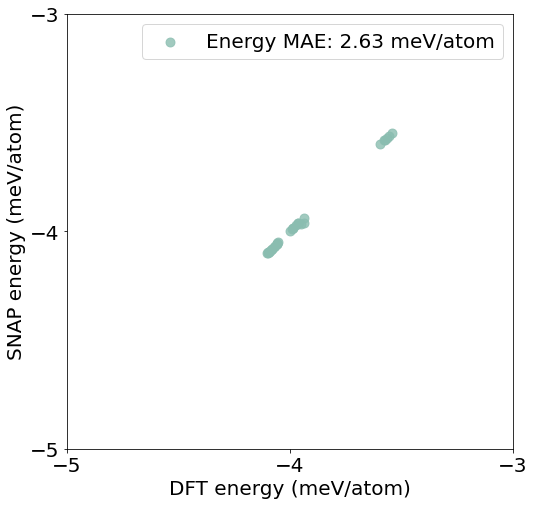

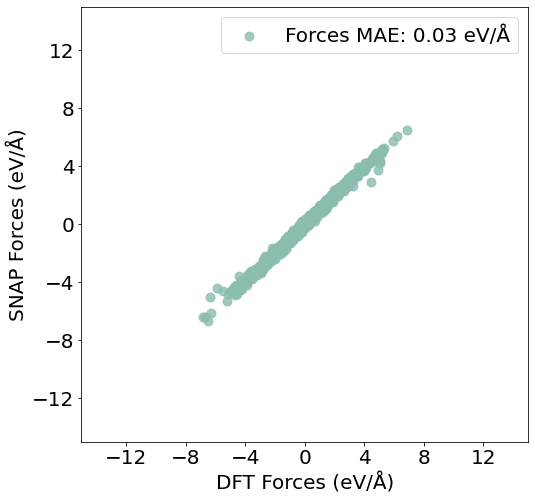

In [20]:
energy_indices = np.argwhere(np.array(df_orig["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(df_orig["dtype"]) == "force").ravel()
orig = df_orig['y_orig']/df_orig['n']
predict = df_predict['y_orig']/df_orig['n']

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(orig[energy_indices], predict[energy_indices], color='#8ABDB0', s=80, alpha=0.8, 
            label="Energy MAE: {:.2f} meV/atom".format(mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000))
ax1.set_xlim(-5, -3)
ax1.set_ylim(-5, -3)
ax1.set_xlabel("DFT energy (meV/atom)", fontsize=20)
ax1.set_ylabel("SNAP energy (meV/atom)", fontsize=20)
ax1.legend(fontsize=20)

from matplotlib import ticker

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))

fig, ax2 = plt.subplots(figsize=(8, 8))
ax2.scatter(orig[forces_indices], predict[forces_indices], color='#8ABDB0', s=80, alpha=0.8,
            label="Forces MAE: {:.2f} eV/Å".format(mean_absolute_error(orig[forces_indices], predict[forces_indices])))
ax2.set_xlim(-15, 15)
ax2.set_ylim(-15, 15)
ax2.set_xlabel("DFT Forces (eV/Å)", fontsize=20)
ax2.set_ylabel("SNAP Forces (eV/Å)", fontsize=20)
ax2.legend(fontsize=20)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(4))

In [21]:
mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000

2.633075661278017

In [7]:
mean_absolute_error(orig[forces_indices], predict[forces_indices])

0.031302449816335454

### 2.3 Predict basic properties

**1. lattice constants prediction** See [LatticeConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

inputs:
 - ff_settings: The potential object. Take SNAPotential as input here.

In [22]:
Cu_cell = Structure.from_spacegroup(sg='Fm-3m', species=['Cu'], lattice=Lattice.cubic(3.62), coords=[[0, 0, 0]])

Cu_lc_calculator = LatticeConstant(Cu_snap)
a, b, c = Cu_lc_calculator.calculate([Cu_cell])[0]
print('Cu', 'Lattice a: {:.3f} Å, Lattice b: {:.3f} Å, Lattice c: {:.3f} Å'.format(a, b, c))

Cu Lattice a: 3.631 Å, Lattice b: 3.631 Å, Lattice c: 3.631 Å


**2. elastic constants prediction** See [ElasticConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.
 - atom_type: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).

In [23]:
Cu_ec_calculator = ElasticConstant(ff_settings=Cu_snap)
Cu_elastic_prop = Cu_ec_calculator.calculate(Cu_train_structures)
print('Cu', ' C11: {:.0f} GPa'.format(Cu_elastic_prop[0][0]), 'C12: {:.0f} GPa'.format(Cu_elastic_prop[0][1]),
      'C44: {:.0f} GPa'.format(Cu_elastic_prop[0][2]), 'Bulk Modulus: {:.0f}'.format(Cu_elastic_prop[0][3]))

Cu  C11: 145 GPa C12: 101 GPa C44: 67 GPa Bulk Modulus: 113


**3. Vacancy formation energy prediction** See [DefectFormation calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - specie: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.

In [24]:
Cu_vacancy_calcualtor = DefectFormation(ff_settings=Cu_snap, specie='Cu', lattice='fcc', alat=3.62)
formation_energy = Cu_vacancy_calcualtor.calculate()
print('Cu Vacancy formation energy: {:.2f} eV'.format(formation_energy))

Cu Vacancy formation energy: 0.99 eV
